In [652]:
import matplotlib.pyplot as plt
from scipy.io import readsav
import numpy as np
import copy
from helita.io import lp
from astropy.io import fits
import sunpy.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening, binary_closing
from skimage.morphology import diamond,ball
import h5py
from scipy.spatial import distance
from multiprocessing import Pool

In [144]:
def geometric_center(x_indices,y_indices):
    '''This function is to 
    compute the geometric center 
    of multiple X and Y coords.
    
    Inputs:
    x_indices: an array of x coordinates. Can be a singleton
    y_indices: an array of y coordinates. Can be a singleton'''
    if len(x_indices) and len(y_indices) !=0:
        X_cog = np.mean(x_indices) # Returning the mean position of the x_indices
        Y_cog = np.mean(y_indices) # --------------do---------------------------
        
    else:
        X_cog = np.nan
        Y_cog = np.nan
    return X_cog, Y_cog

In [391]:
def area_weighted_cog(x,y,area):
    '''Computing COG weighted by area
    
    Inputs:
    x: an array of x coordinates of 2D centroids.
    y: an array of y coordinates of 2D centroids.
    area: area for each of the 2D labels.
    ####--all three must be of the same length'''
    if len(x) and len(y) !=0:
        x_cog = np.zeros((len(x)))
        y_cog = x_cog*0
        for l in range(len(x)):
            x_cog[l] = x[l]*area[l]
            y_cog[l] = y[l]*area[l]
        X_COG = np.sum(x_cog)/np.sum(area)
        Y_COG = np.sum(y_cog)/np.sum(area)
    else:
        X_COG = np.nan
        Y_COG = np.nan
    return X_COG, Y_COG
    

In [2]:
dpath = '/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/crispex/09:12:00/'
dpath_area = '/mn/stornext/d9/souvikb/K_means_results/savefiles/'
dpath_cluster_fits= '/mn/stornext/d9/souvikb/K_means_results/'
dpath_timesteps ='/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/calib_tseries/'
dpath_npz = '/mn/stornext/d9/souvikb/K_means_results/'

In [3]:
cluster_mask = fits.getdata(dpath_cluster_fits+'clusters_mask.fits',ext=0)# Reading the Cluster mask time series
hdrH_im =lp.getheader(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
hdrH_sp = lp.getheader(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris_sp.icube')
dimH_im = hdrH_im[0]
dimH_sp = hdrH_sp[0]
cubeH = lp.getdata(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
cubeH = np.reshape(cubeH,[dimH_im[0],dimH_im[1],dimH_sp[1],dimH_sp[0]])
time_sst = readsav(dpath_timesteps+'tseries_3950_2017-05-25T09:12:00_scans=0-424_calib.sav')
time_sst=time_sst['time']
hdr_Mag = lp.getheader(dpath+'Blos_6302_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
dim_Mag = hdr_Mag[0]
cube_Mag = lp.getdata(dpath+'Blos_6302_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
cube_Mag = np.reshape(cube_Mag,[dim_Mag[0],dim_Mag[1],dim_Mag[2]])
cube_Mag=np.swapaxes(cube_Mag,0,1)
h_alpha=np.swapaxes(cubeH,0,1)

In [4]:
#Labelling the clusters in 3D by considering all the structures. 
cluster_interest_red = [18,46,26,36,8,16] # considering the shadows as well. 
master_aux_cube_red=cluster_mask*0
for clust_index in range(len(cluster_interest_red)):
    master_aux_cube_red[np.where(cluster_mask == cluster_interest_red[clust_index])] = 1.

In [7]:
selem = diamond(1)
morph_processed_red = master_aux_cube_red*0.
for scan in range(425):
    morph_processed_red[:,:,scan] = binary_closing(binary_opening(master_aux_cube_red[:,:,scan],selem),selem) # Morph_open followed by Morph_closing operation to get rid of the salt

In [8]:
#labelling the 3d cube
labeled_3d_red = label(morph_processed_red,return_num=True, connectivity=2)

In [10]:
labeled_3d_red[0].shape

(1641, 1518, 425)

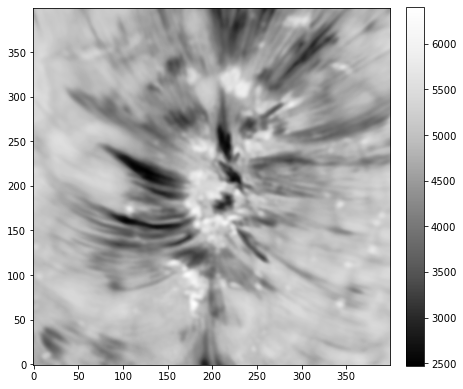

In [128]:
plt.figure(figsize=(7,7))
plt.imshow(h_alpha[800:1200,550:950,418,24],origin='lower',cmap='Greys_r')
plt.colorbar(fraction=0.046, pad=0.04)

In [548]:
mean_abs_mag=np.mean(np.abs(cube_Mag),axis=2)
mask = mean_abs_mag*0
mask[np.where(mean_abs_mag>=100)]=1.

In [641]:
labels_in_roi =[]
for region in regionprops(labeled_3d_red[0]):
    labels_in_roi.append(region.label)

In [642]:
len(labels_in_roi)

27488

### Analyses similar to length statistics

In [643]:
label_2d_cube=[]
count =0
new_count = np.zeros((425)) # used to store those label numbers which are treeated as background in sequential labelling

In [644]:
#Yes, similar analyses, but the FOV is limited
for time in range(425): 
	#reference_mask= closing(master_aux_cube[:,:,time],selem=np.ones((3,3),np.uint8)) # doing a moprh closing on the BW mask
	reference_mask = morph_processed_red[:,:,time]
	label_2d = label(reference_mask,connectivity=2,return_num=True)
	label_numbers = label_2d[1]
	if time ==0:
		label_2d_cube.append(label_2d[0])
	elif time>0:
		label_2d_cube.append(label_2d[0]+count) # serial labels.
	count = count +label_numbers # keeprs track of the labels
	new_count[time] = count
    #print(count,label_numbers)

In [645]:
cube_with_2d_label = np.array(label_2d_cube) # converts the list to a numpy array suited to our analysis. 
label_2d_proper_dim=np.swapaxes(np.swapaxes(cube_with_2d_label,0,2),0,1) # changing the dimension to the dimension of labelled_unmorphed[0]

####-----------computing the parameters for each of the labels in 2D and storing them-------
centroid1=[]
label_2d=[]
area_2d=[]

In [646]:
print("Now computing the centroids from the 2D labelled 3D cube")
for time in range(425):
    for region in regionprops(label_2d_proper_dim[:,:,time]):
        if region.label in new_count: # checking if the labels are from the background labels. If so, then  
            continue                  # skip this and return the control to the beginning to the inner for loop         
        cog = region.centroid
        centroid1.append(cog)
        lab_no=region.label
        label_2d.append(lab_no)
        area_roi = region.area
        area_2d.append(area_roi)


Now computing the centroids from the 2D labelled 3D cube


In [647]:
centroid1 = np.array(centroid1)
label_2d = np.array(label_2d)
area_2d = np.array(area_2d)

In [648]:
centroid1.shape

(142406, 2)

In [649]:
#ref_pt = (200,200)
#lab_test=1100
position_per_label=[]
for regions in range(len(labels_in_roi)):
    time_indices = np.where(labeled_3d_red[0] == labels_in_roi[regions])
    #print(np.unique(np.sort(time_indices[2])))#This will print the no. of time steps that a label exists in 3D. 
    unique_time_indices = np.unique(np.sort(time_indices[2]))
    position_per_time = []
    for time in range(len(unique_time_indices)):
        spatial_index=np.where(labeled_3d_red[0][:,:,unique_time_indices[time]] == labels_in_roi[regions])
        unique_spatial_index = np.unique(label_2d_proper_dim[spatial_index[0],spatial_index[1],unique_time_indices[time]])
        index1 = np.where(np.isin(unique_spatial_index,new_count)== False) # index1 is making sure unique_spatial_index is not in new_count. 
        if len(index1[0])==0:
            position = (np.nan,np.nan)
            position_per_time.append(position)
        else:
            index_2Dlab =np.where(np.isin(label_2d,unique_spatial_index[index1])==True)
            area_index_2Dlab = area_2d[index_2Dlab[0]]
            position = area_weighted_cog(centroid1[index_2Dlab[0],0],centroid1[index_2Dlab[0],1],area_index_2Dlab)
            #distance_from_ref[time] = distance.euclidean(position,ref_pt)
            position_per_time.append(position)
    position_per_label.append(position_per_time)

KeyboardInterrupt: 

In [651]:
def computing_pos_labels(labels_in_roi):
    '''This function is designed to
    compute the position of COG per label
    over the whole time of its existence'''
    time_indices = np.where(labeled_3d_red[0] == labels_in_roi)
    unique_time_indices = np.unique(np.sort(time_indices[2]))
    position_per_time = []
    for time in range(len(unique_time_indices)):
        spatial_index=np.where(labeled_3d_red[0][:,:,unique_time_indices[time]] == labels_in_roi)
        unique_spatial_index = np.unique(label_2d_proper_dim[spatial_index[0],spatial_index[1],unique_time_indices[time]])
        index1 = np.where(np.isin(unique_spatial_index,new_count)== False) # index1 is making sure unique_spatial_index is not in new_count. 
        if len(index1[0])==0:
            position = (np.nan,np.nan)
            position_per_time.append(position)
        else:
            index_2Dlab =np.where(np.isin(label_2d,unique_spatial_index[index1])==True)
            area_index_2Dlab = area_2d[index_2Dlab[0]]
            position = area_weighted_cog(centroid1[index_2Dlab[0],0],centroid1[index_2Dlab[0],1],area_index_2Dlab)
            position_per_time.append(position)
    return position_per_time

In [653]:
pool=Pool(4)
result = pool.map(computing_pos_labels, [100,1,42667,4323])
data = np.array(result)
pool.close()
pool.join()

In [663]:
data[1]

[(7.285714285714286, 428.5),
 (7.699115044247788, 431.60176991150445),
 (9.0, 433.4387755102041),
 (9.540229885057473, 433.18390804597703),
 (8.698795180722891, 433.6305220883534),
 (8.342342342342342, 436.1141141141141),
 (8.469594594594595, 434.7837837837838),
 (8.431034482758621, 435.2988505747126),
 (9.14769975786925, 434.271186440678),
 (9.37037037037037, 433.9037037037037),
 (9.811083123425693, 434.5037783375315),
 (8.425414364640883, 437.64088397790056),
 (10.020594965675057, 438.3363844393593),
 (10.466809421841543, 438.6980728051392),
 (10.241228070175438, 437.7763157894737),
 (10.014742014742014, 437.44717444717446),
 (10.225247524752476, 437.21287128712873),
 (8.856382978723405, 438.75531914893617),
 (7.315436241610739, 439.4765100671141),
 (7.9787234042553195, 439.7051671732523),
 (7.4, 439.35185185185185),
 (5.5, 439.1630434782609),
 (3.638888888888889, 438.8796296296296),
 (3.607142857142857, 439.04464285714283),
 (2.7962962962962963, 438.75925925925924)]

In [661]:
labels_in_roi[20000]

20001

In [422]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 1. the idea should stem from the fact that we have to check how long does each label in labels_in_roi exists in the cube labeled_3d_red[0]
# 2. This is to be followed by a check on a per time-step basis, i.e. how many regions in 2D belong to one single label in 3D.
##-- performed by index=np.where(labeled_3d_red[0][800:1200,550:950,421] == labels_in_roi[1000])
# 3. Next, we compute the number of unique labels (regions) in 2D as found in the above step for that same time-step. 
# 4. Of course, we need to perform the check if any of those labels belong to new_count and not consider them if they do. 
# 5. Next, compute the correct indices in order to obtain their centroids, i.e res1 =np.where(np.isin(label_2d,xx[index1])==True)
# 6. Therefore, res1 gives us the exact x coordinates of the centroid1 from which we can calculate the centroid values. 
# 7. V. Imp--> If we have multiple centroid values for a given time step, it is better to take the mean of distances for all cof values.
# 8. Repeat the steps for the next time step and you will get the distance of each cog per scan wrt a fixed point (200,200). 
# 9. You can then think what to do with the array of that.

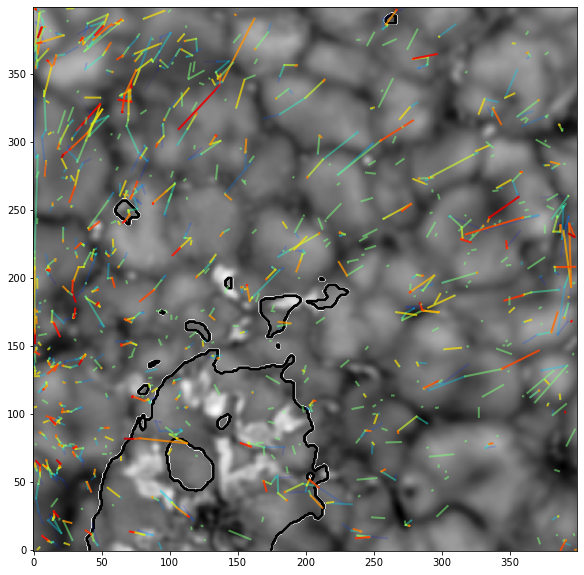

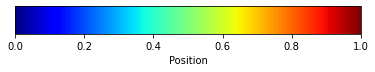

In [640]:
fig,ax1 = plt.subplots(figsize=(10,10))
import matplotlib as mpl
#CONSTANTS

COLOR='blue'
MAP='jet' # choose carefully, or color transitions will not appear smoooth
for event in range(len(position_per_label[:])):
    pos_test=np.array(position_per_label[event])
    if len(pos_test[:,0])<=2 or len(pos_test[:,0]) >=20:
        continue
    else:
        x = pos_test[:,0]
        y = pos_test[:,1]
        NPOINTS = len(x)

        # Choose a color map, loop through the colors, and assign them to the color 
        # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
        # between pairs. In other words, your line is not cyclic, so there's 
        # no line from end to beginning
        cm = plt.get_cmap(MAP)
        ax1.set_prop_cycle(color=[cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
        for i in range(NPOINTS-1):
            ax1.plot(x[i:i+2],y[i:i+2],linewidth=2,alpha=float(i)/(NPOINTS-1))

ax1.imshow(h_alpha[1000:1400,650:1050,418,31],origin='lower',cmap='Greys_r')
ax1.contour(mask[1000:1400,650:1050],cmap='Greys',levels=110)
fig1, ax = plt.subplots(figsize=(6, 1))
fig1.subplots_adjust(left=0.2,bottom=0.5,right=1)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Position')
plt.savefig('/mn/stornext/d9/souvikb/paper4_images/RRE_direction_FOV2_alpha_v2.pdf',dpi=300,format='pdf')

## Version 2: A bit more agrressive morph_open, but now with a 3D structuring element.

In [579]:
#Different structuring element
selem_ball = ball(1)
morph_ball_processed = master_aux_cube_red*0.
morph_ball_processed = binary_closing(binary_opening(master_aux_cube_red,selem_ball),selem_ball)



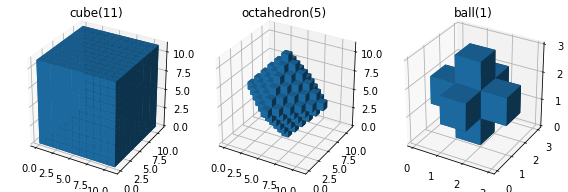

In [580]:
from mpl_toolkits.mplot3d import Axes3D
from skimage.morphology import (square, rectangle, diamond, disk, cube,
                                octahedron, ball, octagon, star)
struc_3d = {
    "cube(11)": cube(11),
    "octahedron(5)": octahedron(5),
    "ball(1)": ball(1)
}
fig = plt.figure(figsize=(8, 8))
idx = 1
for title, struc in struc_3d.items():
    ax = fig.add_subplot(3, 3, idx, projection=Axes3D.name)
    ax.voxels(struc)
    ax.set_title(title)
    idx += 1

fig.tight_layout()
plt.show()

In [581]:
labeled_3d_red_ball = label(morph_ball_processed,return_num=True, connectivity=2)


In [582]:
labeled_3d_red_ball[1]

15762

In [583]:
labels_in_roi_v2 =[]
for region in regionprops(labeled_3d_red_ball[0][1000:1400,650:1050,:]):
    labels_in_roi_v2.append(region.label)

In [613]:
label_2d_cube=[]
count =0
new_count = np.zeros((425)) # used to store those label numbers which are treeated as background in sequential labelling

In [614]:
#Yes, similar analyses, but the FOV is limited
for time in range(425): 
	#reference_mask= closing(master_aux_cube[:,:,time],selem=np.ones((3,3),np.uint8)) # doing a moprh closing on the BW mask
	reference_mask = morph_ball_processed[1000:1400,650:1050,time]
	label_2d = label(reference_mask,connectivity=2,return_num=True)
	label_numbers = label_2d[1]
	if time ==0:
		label_2d_cube.append(label_2d[0])
	elif time>0:
		label_2d_cube.append(label_2d[0]+count) # serial labels.
	count = count +label_numbers # keeprs track of the labels
	new_count[time] = count
    #print(count,label_numbers)

In [615]:
cube_with_2d_label = np.array(label_2d_cube) # converts the list to a numpy array suited to our analysis. 
label_2d_proper_dim=np.swapaxes(np.swapaxes(cube_with_2d_label,0,2),0,1) # changing the dimension to the dimension of labelled_unmorphed[0]

####-----------computing the parameters for each of the labels in 2D and storing them-------
centroid1=[]
label_2d=[]
area_2d=[]

In [616]:
print("Now computing the centroids from the 2D labelled 3D cube")
for time in range(425):
    for region in regionprops(label_2d_proper_dim[:,:,time]):
        if region.label in new_count: # checking if the labels are from the background labels. If so, then  
            continue                  # skip this and return the control to the beginning to the inner for loop         
        cog = region.centroid
        centroid1.append(cog)
        lab_no=region.label
        label_2d.append(lab_no)
        area_roi = region.area
        area_2d.append(area_roi)

Now computing the centroids from the 2D labelled 3D cube


In [617]:
centroid1 = np.array(centroid1)
label_2d = np.array(label_2d)
area_2d = np.array(area_2d)

In [618]:
#ref_pt = (200,200)
#lab_test=1100
position_per_label=[]
for regions in range(len(labels_in_roi_v2)):
    time_indices = np.where(labeled_3d_red_ball[0][1000:1400,650:1050,:] == labels_in_roi_v2[regions])
    #print(np.unique(np.sort(time_indices[2])))#This will print the no. of time steps that a label exists in 3D. 
    unique_time_indices = np.unique(np.sort(time_indices[2]))
    position_per_time = []
    for time in range(len(unique_time_indices)):
        spatial_index=np.where(labeled_3d_red_ball[0][1000:1400,650:1050,unique_time_indices[time]] == labels_in_roi_v2[regions])
        unique_spatial_index = np.unique(label_2d_proper_dim[spatial_index[0],spatial_index[1],unique_time_indices[time]])
        index1 = np.where(np.isin(unique_spatial_index,new_count)== False) # index1 is making sure unique_spatial_index is not in new_count. 
        if len(index1[0])==0:
            position = (np.nan,np.nan)
            position_per_time.append(position)
        else:
            index_2Dlab =np.where(np.isin(label_2d,unique_spatial_index[index1])==True)
            area_index_2Dlab = area_2d[index_2Dlab[0]]
            position = area_weighted_cog(centroid1[index_2Dlab[0],0],centroid1[index_2Dlab[0],1],area_index_2Dlab)
            #distance_from_ref[time] = distance.euclidean(position,ref_pt)
            position_per_time.append(position)
    position_per_label.append(position_per_time)

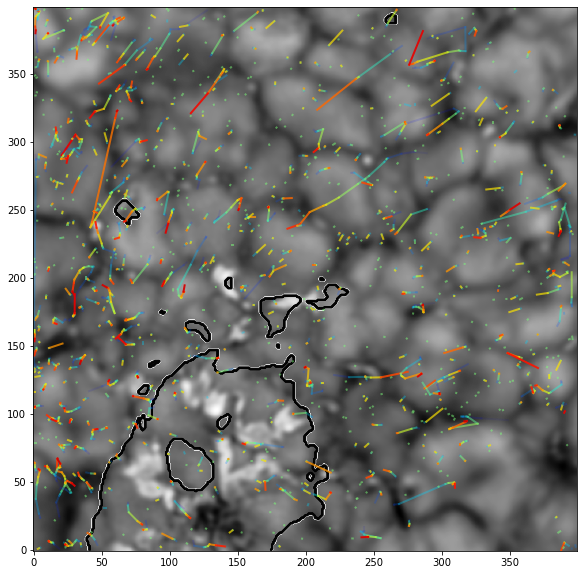

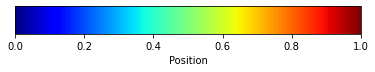

In [619]:
fig,ax1 = plt.subplots(figsize=(10,10))
import matplotlib as mpl
#CONSTANTS

COLOR='blue'
MAP='jet' # choose carefully, or color transitions will not appear smoooth
for event in range(len(position_per_label[:])):
    pos_test=np.array(position_per_label[event])
    if len(pos_test[:,0])<=2 or len(pos_test[:,0]) >=17:
        continue
    else:
        x = pos_test[:,0]
        y = pos_test[:,1]
        NPOINTS = len(x)

        # Choose a color map, loop through the colors, and assign them to the color 
        # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
        # between pairs. In other words, your line is not cyclic, so there's 
        # no line from end to beginning
        cm = plt.get_cmap(MAP)
        ax1.set_prop_cycle(color=[cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
        for i in range(NPOINTS-1):
            ax1.plot(x[i:i+2],y[i:i+2],linewidth=2,alpha=float(i)/(NPOINTS-1))

ax1.imshow(h_alpha[1000:1400,650:1050,418,31],origin='lower',cmap='Greys_r')
ax1.contour(mask[1000:1400,650:1050],cmap='Greys',levels=110)
fig1, ax = plt.subplots(figsize=(6, 1))
fig1.subplots_adjust(left=0.2,bottom=0.5,right=1)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Position')
plt.savefig('/mn/stornext/d9/souvikb/paper4_images/RRE_direction_FOV2_alpha.pdf',dpi=300,format='pdf')

## Version 3: Same like Version 1 but just a change of the FOV equal to Version2. 


In [620]:
label_2d_cube_v3=[]
count_v3 =0
new_count_v3 = np.zeros((425)) # used to store those label numbers which are treeated as background in sequential labelling

In [621]:
#Yes, similar analyses, but the FOV is limited
for time in range(425): 
	#reference_mask= closing(master_aux_cube[:,:,time],selem=np.ones((3,3),np.uint8)) # doing a moprh closing on the BW mask
	reference_mask = morph_processed_red[1000:1400,650:1050,time]
	label_2d_v3 = label(reference_mask,connectivity=2,return_num=True)
	label_numbers = label_2d_v3[1]
	if time ==0:
		label_2d_cube_v3.append(label_2d_v3[0])
	elif time>0:
		label_2d_cube_v3.append(label_2d_v3[0]+count) # serial labels.
	count = count +label_numbers # keeprs track of the labels
	new_count_v3[time] = count
    #print(count,label_numbers)

In [622]:
cube_with_2d_label_v3 = np.array(label_2d_cube_v3) # converts the list to a numpy array suited to our analysis. 
label_2d_proper_dim_v3=np.swapaxes(np.swapaxes(cube_with_2d_label_v3,0,2),0,1) # changing the dimension to the dimension of labelled_unmorphed[0]

####-----------computing the parameters for each of the labels in 2D and storing them-------
centroid1_v3=[]
label_2d_v3=[]
area_2d_v3=[]

In [623]:
print("Now computing the centroids from the 2D labelled 3D cube")
for time in range(425):
    for region in regionprops(label_2d_proper_dim_v3[:,:,time]):
        if region.label in new_count_v3: # checking if the labels are from the background labels. If so, then  
            continue                  # skip this and return the control to the beginning to the inner for loop         
        cog = region.centroid
        centroid1_v3.append(cog)
        lab_no=region.label
        label_2d_v3.append(lab_no)
        area_roi = region.area
        area_2d_v3.append(area_roi)



Now computing the centroids from the 2D labelled 3D cube


In [624]:
centroid1_v3 = np.array(centroid1_v3)
label_2d_v3 = np.array(label_2d_v3)
area_2d_v3 = np.array(area_2d_v3)

In [627]:
#ref_pt = (200,200)
#lab_test=1100
position_per_label_v3=[]
for regions in range(len(labels_in_roi)):
    time_indices = np.where(labeled_3d_red[0][1000:1400,650:1050,:] == labels_in_roi[regions])
    #print(np.unique(np.sort(time_indices[2])))#This will print the no. of time steps that a label exists in 3D. 
    unique_time_indices = np.unique(np.sort(time_indices[2]))
    position_per_time = []
    for time in range(len(unique_time_indices)):
        spatial_index=np.where(labeled_3d_red[0][1000:1400,650:1050,unique_time_indices[time]] == labels_in_roi[regions])
        unique_spatial_index = np.unique(label_2d_proper_dim_v3[spatial_index[0],spatial_index[1],unique_time_indices[time]])
        index1 = np.where(np.isin(unique_spatial_index,new_count_v3)== False) # index1 is making sure unique_spatial_index is not in new_count. 
        if len(index1[0])==0:
            position = (np.nan,np.nan)
            position_per_time.append(position)
        else:
            index_2Dlab =np.where(np.isin(label_2d_v3,unique_spatial_index[index1])==True)
            area_index_2Dlab = area_2d_v3[index_2Dlab[0]]
            position = area_weighted_cog(centroid1_v3[index_2Dlab[0],0],centroid1_v3[index_2Dlab[0],1],area_index_2Dlab)
            #distance_from_ref[time] = distance.euclidean(position,ref_pt)
            position_per_time.append(position)
    position_per_label_v3.append(position_per_time)

IndexError: too many indices for array

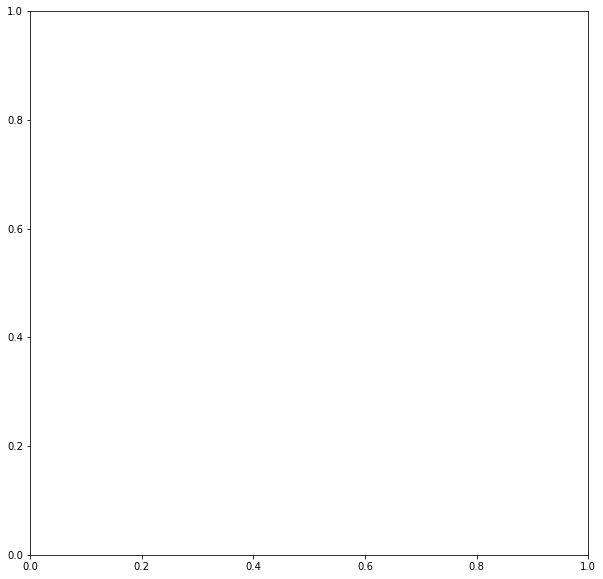

In [628]:
fig,ax1 = plt.subplots(figsize=(10,10))
import matplotlib as mpl
#CONSTANTS

COLOR='blue'
MAP='jet' # choose carefully, or color transitions will not appear smoooth
for event in range(len(position_per_label_v3[:])):
    pos_test=np.array(position_per_label_v3[event])
    if len(pos_test[:,0])<=2 or len(pos_test[:,0]) >=18:
        continue
    else:
        x = pos_test[:,0]
        y = pos_test[:,1]
        NPOINTS = len(x)

        # Choose a color map, loop through the colors, and assign them to the color 
        # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
        # between pairs. In other words, your line is not cyclic, so there's 
        # no line from end to beginning
        cm = plt.get_cmap(MAP)
        ax1.set_prop_cycle(color=[cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
        for i in range(NPOINTS-1):
            ax1.plot(x[i:i+2],y[i:i+2],linewidth=2,alpha=float(i)/(NPOINTS-1))

ax1.imshow(h_alpha[1000:1400,650:1050,418,31],origin='lower',cmap='Greys_r')
ax1.contour(mask[1000:1400,650:1050],cmap='Greys',levels=110)
fig1, ax = plt.subplots(figsize=(6, 1))
fig1.subplots_adjust(left=0.2,bottom=0.5,right=1)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Position')
plt.savefig('/mn/stornext/d9/souvikb/paper4_images/RRE_direction_FOV2_alpha_v2.pdf',dpi=300,format='pdf')

## For the full FOV

### RRE

In [869]:
def interPolatedPoints(x,y,factor):
    '''Take points listed in two vectors 
    and return them at a higher resultion. 

    Returns new x and y arrays as a tuple (x,y). '''
    
    #x = pos_test[:,1]
    #y =pos_test[:,0]
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1]
        dy = y[i]-y[i-1]
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    dr = rtot[-1]/(NPOINTS*RESFACT-1)
    xmod=[x[0]]
    ymod=[y[0]]
    rPos = 0 # current point on walk along data
    rcount = 1 
    while rPos < r.sum():
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        dpos = rPos-rtot[rcount] 
        theta = np.arctan2((x2-x1),(y2-y1))
        rx = np.sin(theta)*dpos+x1
        ry = np.cos(theta)*dpos+y1
        xmod.append(rx)
        ymod.append(ry)
        rPos+=dr
        while rPos > rtot[rcount+1]:
            rPos = rtot[rcount+1]
            rcount+=1
            if rcount>rtot[-1] or rcount>=len(x):
                break
    return xmod,ymod

In [808]:
data1 = np.load(dpath_npz+'rre_COG_positions_per_label.npz',allow_pickle=True)
new_data1 = data1['arr_0']

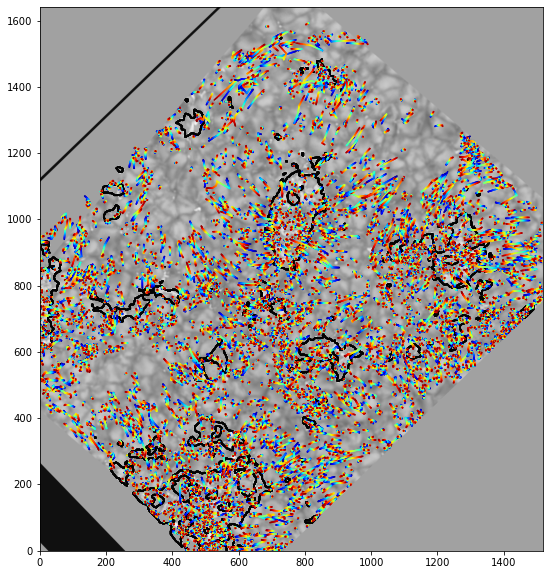

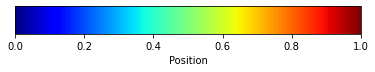

In [868]:
fig,ax1 = plt.subplots(figsize=(10,10))
import matplotlib as mpl
#CONSTANTS

COLOR='blue'
MAP='jet' # choose carefully, or color transitions will not appear smoooth
for event in range(len(new_data1[:])):
    pos_test=np.array(new_data1[event])
    if len(pos_test[:,0])<=3 or len(pos_test[:,0]) >18 or np.isnan(np.min(pos_test[:,0])) == True:
        continue
    else:
#         if len(pos_test[:,0])<=5:
            x = pos_test[:,1]
            y = pos_test[:,0]
            RESFACT =5
            NPOINTS = len(x)
            xHiRes,yHiRes = interPolatedPoints(x,y,RESFACT)
            npointsHiRes = len(xHiRes)
            # Choose a color map, loop through the colors, and assign them to the color 
            # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
            # between pairs. In other words, your line is not cyclic, so there's 
            # no line from end to beginning
            cm = plt.get_cmap(MAP)
            ax1.set_prop_cycle(color=[cm(1.*i/(npointsHiRes-1)) for i in range(npointsHiRes-1)])
            for i in range(npointsHiRes-1):
                ax1.plot(xHiRes[i:i+2],yHiRes[i:i+2],linewidth=1.5)
#         else:
#             x = pos_test[:,1]
#             y = pos_test[:,0]
#             NPOINTS = len(x)

#             # Choose a color map, loop through the colors, and assign them to the color 
#             # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
#             # between pairs. In other words, your line is not cyclic, so there's 
#             # no line from end to beginning
#             cm = plt.get_cmap(MAP)
#             ax1.set_prop_cycle(color=[cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
#             for i in range(NPOINTS-1):
#                 ax1.plot(x[i:i+2],y[i:i+2],linewidth=2)

ax1.imshow(h_alpha[:,:,418,31],origin='lower',cmap='Greys_r')
ax1.contour(mask,cmap='Greys',levels=110)
fig1, ax = plt.subplots(figsize=(6, 1))
fig1.subplots_adjust(left=0.2,bottom=0.5,right=1)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Position')
#plt.savefig('/mn/stornext/d9/souvikb/paper4_images/RRE_direction_FOV2_alpha_v2.pdf',dpi=300,format='pdf')

### RBE

In [881]:
data2 = np.load(dpath_npz+'rbe_COG_positions_per_label.npz',allow_pickle=True)
new_data2 = data2['arr_0']

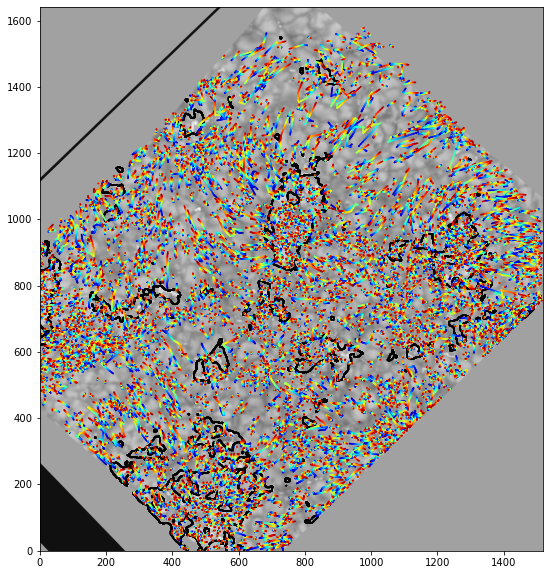

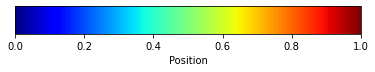

In [882]:
fig,ax1 = plt.subplots(figsize=(10,10))
import matplotlib as mpl
#CONSTANTS

COLOR='blue'
MAP='jet' # choose carefully, or color transitions will not appear smoooth
for event in range(len(new_data2[:])):
    pos_test=np.array(new_data2[event])
    if len(pos_test[:,0])<=3 or len(pos_test[:,0]) >18 or np.isnan(np.min(pos_test[:,0])) == True:
        continue
    else:
#         if len(pos_test[:,0])<=5:
            x = pos_test[:,1]
            y = pos_test[:,0]
            RESFACT =3
            NPOINTS = len(x)
            xHiRes,yHiRes = interPolatedPoints(x,y,RESFACT)
            npointsHiRes = len(xHiRes)
            # Choose a color map, loop through the colors, and assign them to the color 
            # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
            # between pairs. In other words, your line is not cyclic, so there's 
            # no line from end to beginning
            cm = plt.get_cmap(MAP)
            ax1.set_prop_cycle(color=[cm(1.*i/(npointsHiRes-1)) for i in range(npointsHiRes-1)])
            for i in range(npointsHiRes-1):
                ax1.plot(xHiRes[i:i+2],yHiRes[i:i+2],linewidth=1.5)
#         else:
#             x = pos_test[:,1]
#             y = pos_test[:,0]
#             NPOINTS = len(x)

#             # Choose a color map, loop through the colors, and assign them to the color 
#             # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
#             # between pairs. In other words, your line is not cyclic, so there's 
#             # no line from end to beginning
#             cm = plt.get_cmap(MAP)
#             ax1.set_prop_cycle(color=[cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
#             for i in range(NPOINTS-1):
#                 ax1.plot(x[i:i+2],y[i:i+2],linewidth=2)

ax1.imshow(h_alpha[:,:,418,31],origin='lower',cmap='Greys_r')
ax1.contour(mask,cmap='Greys',levels=110)
fig1, ax = plt.subplots(figsize=(6, 1))
fig1.subplots_adjust(left=0.2,bottom=0.5,right=1)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Position')
#plt.savefig('/mn/stornext/d9/souvikb/paper4_images/RRE_direction_FOV2_alpha_v2.pdf',dpi=300,format='pdf')

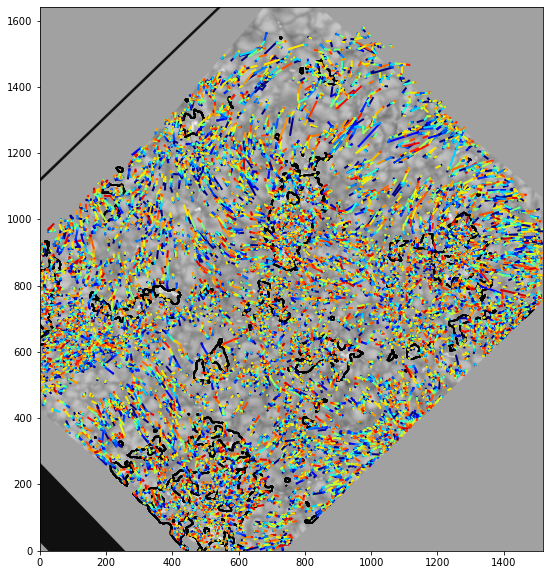

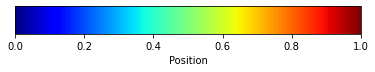

In [880]:
fig,ax1 = plt.subplots(figsize=(10,10))
import matplotlib as mpl
#CONSTANTS

COLOR='blue'
MAP='jet' # choose carefully, or color transitions will not appear smoooth
for event in range(len(new_data2[:])):
    pos_test=np.array(new_data2[event])
    if len(pos_test[:,0])<=3 or len(pos_test[:,0]) >18 or np.isnan(np.min(pos_test[:,0])) == True:
        continue
    else:
#         if len(pos_test[:,0])<=5:
#             x = pos_test[:,1]
#             y = pos_test[:,0]
#             RESFACT =5
#             NPOINTS = len(x)
#             xHiRes,yHiRes = interPolatedPoints(x,y,RESFACT)
#             npointsHiRes = len(xHiRes)
#             # Choose a color map, loop through the colors, and assign them to the color 
#             # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
#             # between pairs. In other words, your line is not cyclic, so there's 
#             # no line from end to beginning
#             cm = plt.get_cmap(MAP)
#             ax1.set_prop_cycle(color=[cm(1.*i/(npointsHiRes-1)) for i in range(npointsHiRes-1)])
#             for i in range(npointsHiRes-1):
#                 ax1.plot(xHiRes[i:i+2],yHiRes[i:i+2],linewidth=1.5)
#         else:
        x = pos_test[:,1]
        y = pos_test[:,0]
        NPOINTS = len(x)

        # Choose a color map, loop through the colors, and assign them to the color 
        # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
        # between pairs. In other words, your line is not cyclic, so there's 
        # no line from end to beginning
        cm = plt.get_cmap(MAP)
        ax1.set_prop_cycle(color=[cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
        for i in range(NPOINTS-1):
            ax1.plot(x[i:i+2],y[i:i+2],linewidth=2)

ax1.imshow(h_alpha[:,:,418,31],origin='lower',cmap='Greys_r')
ax1.contour(mask,cmap='Greys',levels=110)
fig1, ax = plt.subplots(figsize=(6, 1))
fig1.subplots_adjust(left=0.2,bottom=0.5,right=1)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Position')
#plt.savefig('/mn/stornext/d9/souvikb/paper4_images/RRE_direction_FOV2_alpha_v2.pdf',dpi=300,format='pdf')